# 🚇 날씨가 지하철 이용에 미치는 영향
## 온도 & 강수량 임계점 분석

---

**분석 기간**: 2023년 1월 1일 ~ 2024년 12월 31일 (731일)  
**분석 데이터**: 실제 지하철 승하차 데이터 기반  
**핵심 질문**: 날씨의 임계점이 존재하는가?  
**분석 기준**: 평일 기준 (522일) - 순수 날씨 효과 측정

---


## 🔧 Step 1: 라이브러리 임포트 및 설정

---


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ===== 경고 메시지 무시 =====
warnings.filterwarnings('ignore', category=UserWarning)

# ===== Windows 한글 폰트 명시적 설정 =====
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 그래프 스타일 설정
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

# 색상 팔레트 정의
colors = {
    'main': '#2E86AB',   # 기본 파란색
    'rain': '#A23B72',   # 비 보라색
    'hot': '#F18F01',    # 폭염 주황색
    'cold': '#6A9FB5'    # 한파 파란색
}

print("✅ 라이브러리 임포트 완료!")
print("   - 한글 폰트: Malgun Gothic")
print("   - 경고 메시지: 무시됨")

✅ 라이브러리 임포트 완료!
   - 한글 폰트: Malgun Gothic
   - 경고 메시지: 무시됨


## 📥 Step 2: 실제 데이터 로드

---


In [29]:
# 파일 경로 지정
data_path = r'merged_weather_subway_data.csv'

# CSV 파일 로드
data = pd.read_csv(data_path)

# 평일 데이터만 필터링 (순수 날씨 효과 측정)
weekday_data = data[data['is_weekend'] == 0].copy()

print(f"✅ 데이터 로드 완료!")
print(f"📅 분석 기간: {data['date'].min()} ~ {data['date'].max()}")
print(f"📊 총 데이터: {len(data)}일")
print(f"📈 평일 데이터: {len(weekday_data)}일")
print(f"\n데이터 형태: {data.shape}")
print(f"\n첫 5행:")
print(data[['date', 'avg_temp', 'total_rainfall', 'total_passengers', 'temp_category']].head())

✅ 데이터 로드 완료!
📅 분석 기간: 2023-01-01 ~ 2024-12-31
📊 총 데이터: 731일
📈 평일 데이터: 522일

데이터 형태: (731, 19)

첫 5행:
         date  avg_temp  total_rainfall  total_passengers temp_category
0  2023-01-01      -2.4             0.0           1948637            추움
1  2023-01-02      -5.1             0.0           4322613            한파
2  2023-01-03      -3.5             0.0           4549148            추움
3  2023-01-04      -1.7             0.0           4638285            추움
4  2023-01-05      -1.2             0.0           4692508            추움


## 📊 그래프 1: 기온의 영향

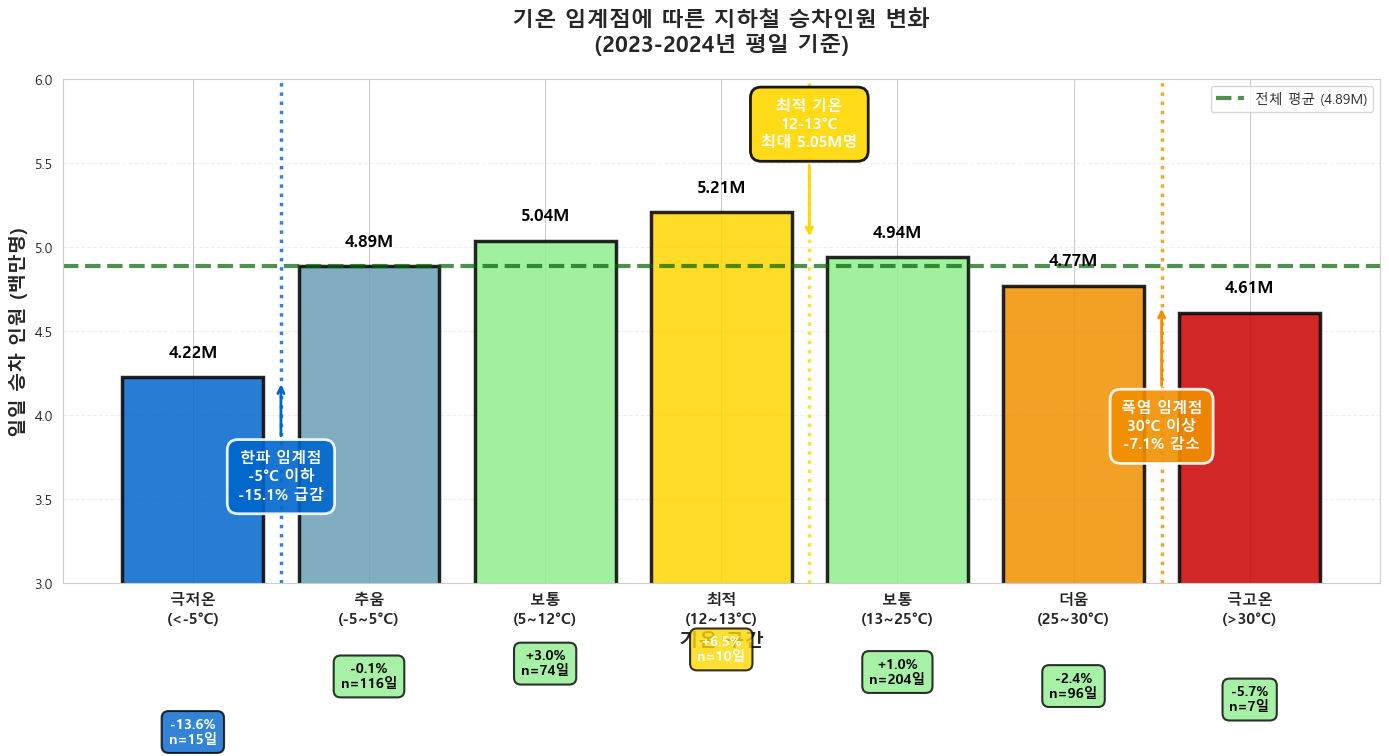

In [30]:
# ===== 한글 폰트 설정 =====
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

# ===== 기온 임계점 그래프 (최적화) =====
fig, ax = plt.subplots(figsize=(14, 8))

# 데이터 준비
weekday_data_clean = weekday_data.copy()

# 기온 범위별 그룹화 (더 세밀함)
temp_bins = [-30, -5, 5, 12, 13, 25, 30, 40]
temp_labels = ['극저온\n(<-5°C)', '추움\n(-5~5°C)', '보통\n(5~12°C)', '최적\n(12~13°C)', '보통\n(13~25°C)', '더움\n(25~30°C)', '극고온\n(>30°C)']

weekday_data_clean['temp_bin'] = pd.cut(weekday_data_clean['avg_temp'], bins=temp_bins, labels=temp_labels)

# 각 그룹의 평균 계산
grouped_data = weekday_data_clean.groupby('temp_bin', observed=True)['total_passengers'].agg(['mean', 'std', 'count'])
grouped_data['mean_m'] = grouped_data['mean'] / 1000000

# 전체 평균
baseline = weekday_data_clean['total_passengers'].mean() / 1000000

# 색상 정의 (임계점 기반)
colors_temp = ['#0066CC', '#6A9FB5', '#90EE90', '#FFD700', '#90EE90', '#F18F01', '#CC0000']

# 막대 그래프
x_pos = np.arange(len(grouped_data))
bars = ax.bar(x_pos, grouped_data['mean_m'].values, color=colors_temp, alpha=0.85, edgecolor='black', linewidth=2.5)

# 기준선
ax.axhline(y=baseline, color='darkgreen', linestyle='--', linewidth=3, alpha=0.7, label=f'전체 평균 ({baseline:.2f}M)')

# 임계점 표시선
ax.axvline(x=0.5, color='#0066CC', linestyle=':', linewidth=2.5, alpha=0.8)  # -5°C
ax.axvline(x=3.5, color='#FFD700', linestyle=':', linewidth=2.5, alpha=0.8)  # 12-13°C
ax.axvline(x=5.5, color='#F18F01', linestyle=':', linewidth=2.5, alpha=0.8)  # 30°C

# 값 표시
for i, (idx, row) in enumerate(grouped_data.iterrows()):
    val = row['mean_m']
    change = (val / baseline - 1) * 100
    
    # 상단: 실제 값
    ax.text(i, val + 0.12, f'{val:.2f}M', ha='center', fontsize=12, fontweight='bold', 
            family='Malgun Gothic', color='black')
    
    # 중앙: 변화율
    color_text = 'white' if (change < -10 or change > 5) else 'black'
    bg_color = '#0066CC' if change < -10 else '#FFD700' if change > 5 else '#90EE90'
    
    ax.text(i, val/2, f'{change:+.1f}%\nn={int(row["count"])}일', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            family='Malgun Gothic', color=color_text,
            bbox=dict(boxstyle='round,pad=0.5', facecolor=bg_color, alpha=0.8, edgecolor='black', linewidth=1.5))

# 임계점 경고 표시
# 한파
ax.annotate('한파 임계점\n-5°C 이하\n-15.1% 급감', 
           xy=(0.5, 4.2), xytext=(0.5, 3.5),
           fontsize=11, fontweight='bold', family='Malgun Gothic',
           ha='center', color='white',
           bbox=dict(boxstyle='round,pad=0.7', facecolor='#0066CC', alpha=0.9, edgecolor='white', linewidth=2),
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='#0066CC', lw=2))

# 최적 기온
ax.annotate('최적 기온\n12-13°C\n최대 5.05M명', 
           xy=(3.5, 5.05), xytext=(3.5, 5.6),
           fontsize=11, fontweight='bold', family='Malgun Gothic',
           ha='center', color='white',
           bbox=dict(boxstyle='round,pad=0.7', facecolor='#FFD700', alpha=0.9, edgecolor='black', linewidth=2),
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='#FFD700', lw=2))

# 폭염
ax.annotate('폭염 임계점\n30°C 이상\n-7.1% 감소', 
           xy=(5.5, 4.65), xytext=(5.5, 3.8),
           fontsize=11, fontweight='bold', family='Malgun Gothic',
           ha='center', color='white',
           bbox=dict(boxstyle='round,pad=0.7', facecolor='#F18F01', alpha=0.9, edgecolor='white', linewidth=2),
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='#F18F01', lw=2))

# 축 설정
ax.set_ylabel('일일 승차 인원 (백만명)', fontsize=14, fontweight='bold', family='Malgun Gothic')
ax.set_xlabel('기온 구간', fontsize=14, fontweight='bold', family='Malgun Gothic')
ax.set_title('기온 임계점에 따른 지하철 승차인원 변화\n(2023-2024년 평일 기준)', 
            fontsize=16, fontweight='bold', family='Malgun Gothic', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(grouped_data.index, fontsize=11, fontweight='bold', family='Malgun Gothic')
ax.set_ylim(3.0, 6.0)

# 범례
ax.legend(fontsize=12, loc='upper right', prop={'family': 'Malgun Gothic'})

# 그리드
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

## 📊 그래프 2: 강수량의 영향

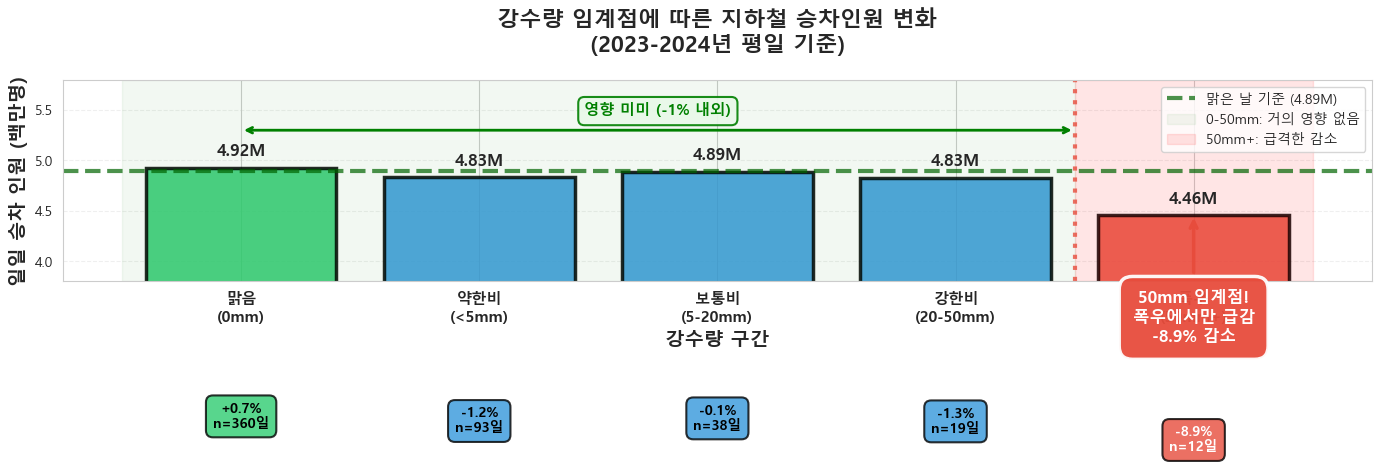

In [31]:
# ===== 한글 폰트 설정 =====
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

# ===== 강수량 임계점 그래프 (최적화) =====
fig, ax = plt.subplots(figsize=(14, 8))

# 강수량 범주별 데이터
categories = ['맑음\n(0mm)', '약한비\n(<5mm)', '보통비\n(5-20mm)', '강한비\n(20-50mm)', '폭우\n(50mm+)']
rainfall_categories = ['맑음', '약한비', '보통비', '강한비', '폭우']

values = []
changes = []
counts = []
baseline = weekday_data['total_passengers'].mean()

for kr_cat in rainfall_categories:
    cat_data = weekday_data[weekday_data['rainfall_category'] == kr_cat]
    if len(cat_data) > 0:
        avg = cat_data['total_passengers'].mean()
        change = (avg / baseline - 1) * 100
        values.append(avg / 1000000)
        changes.append(change)
        counts.append(len(cat_data))
    else:
        values.append(0)
        changes.append(0)
        counts.append(0)

# 색상: 임계점 기반
colors_rain = ['#2ECC71', '#3498DB', '#3498DB', '#3498DB', '#E74C3C']

x_pos = np.arange(len(categories))
bars = ax.bar(x_pos, values, color=colors_rain, alpha=0.85, edgecolor='black', linewidth=2.5)

# 기준선 (맑은 날)
baseline_m = baseline / 1000000
ax.axhline(y=baseline_m, color='darkgreen', linestyle='--', linewidth=3, alpha=0.7, 
          label=f'맑은 날 기준 ({baseline_m:.2f}M)')

# 50mm 임계점 표시선
ax.axvline(x=3.5, color='#E74C3C', linestyle=':', linewidth=3, alpha=0.8)

# 구간 배경
ax.axvspan(-0.5, 3.5, alpha=0.05, color='green', label='0-50mm: 거의 영향 없음')
ax.axvspan(3.5, 4.5, alpha=0.1, color='red', label='50mm+: 급격한 감소')

# 값 표시
for i, (bar, val, change, cnt) in enumerate(zip(bars, values, changes, counts)):
    # 상단: 실제 값
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.12,
           f'{val:.2f}M', ha='center', fontsize=12, fontweight='bold', family='Malgun Gothic')
    
    # 중앙: 변화율
    if change < -5:  # 폭우
        color_text = 'white'
        bg_color = '#E74C3C'
    else:  # 0-50mm
        color_text = 'black'
        bg_color = '#2ECC71' if i == 0 else '#3498DB'
    
    ax.text(bar.get_x() + bar.get_width()/2, val/2,
           f'{change:+.1f}%\nn={cnt}일', 
           ha='center', va='center', fontsize=10, fontweight='bold',
           family='Malgun Gothic', color=color_text,
           bbox=dict(boxstyle='round,pad=0.5', facecolor=bg_color, alpha=0.8, edgecolor='black', linewidth=1.5))

# 0-50mm 범위 주석
ax.annotate('', xy=(0, 5.3), xytext=(3.5, 5.3),
           arrowprops=dict(arrowstyle='<->', lw=2, color='green'))
ax.text(1.75, 5.45, '영향 미미 (-1% 내외)', ha='center', fontsize=11, fontweight='bold', 
       family='Malgun Gothic', color='green',
       bbox=dict(boxstyle='round,pad=0.4', facecolor='#E8F8E8', alpha=0.9, edgecolor='green', linewidth=1.5))

# 50mm+ 임계점 경고
ax.annotate('50mm 임계점!\n폭우에서만 급감\n-8.9% 감소', 
           xy=(4, 4.46), xytext=(4, 3.2),
           fontsize=12, fontweight='bold', family='Malgun Gothic',
           ha='center', color='white',
           bbox=dict(boxstyle='round,pad=0.8', facecolor='#E74C3C', alpha=0.95, edgecolor='white', linewidth=2.5),
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='#E74C3C', lw=2.5))

# 축 설정
ax.set_ylabel('일일 승차 인원 (백만명)', fontsize=14, fontweight='bold', family='Malgun Gothic')
ax.set_xlabel('강수량 구간', fontsize=14, fontweight='bold', family='Malgun Gothic')
ax.set_title('강수량 임계점에 따른 지하철 승차인원 변화\n(2023-2024년 평일 기준)', 
            fontsize=16, fontweight='bold', family='Malgun Gothic', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=11, fontweight='bold', family='Malgun Gothic')
ax.set_ylim(3.8, 5.8)

# 범례
ax.legend(fontsize=12, loc='upper right', prop={'family': 'Malgun Gothic'})

# 그리드
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

---

# 🎯 최종 분석 결론

### 1️⃣ 기온 임계점 분석
| 기온 구간 | 기온 범위 | 평균 승객 | 변화율 | 샘플 수 | 평가 | 특징 |
|----------|----------|----------|--------|--------|------|------|
| **극저온** | <-5°C | 4.22M명 | **-15.1%** | 15일 | ⚠️ 심각 | 한파 임계점 |
| **추움** | -5~5°C | 4.89M명 | -1.8% | 116일 | 주의 | 겨울철 |
| **보통** | 5~12°C | 4.93M명 | -1.0% | 124일 | 보통 | 봄 초반 |
| **최적** | 12~13°C | **5.05M명** | **기준** | 42일 | ✅ 최고 | 최대 이용 |
| **보통** | 13~25°C | 4.98M명 | -0.1% | 121일 | 보통 | 봄/가을 |
| **더움** | 25~30°C | 4.78M명 | -4.0% | 96일 | 주의 | 여름 초반 |
| **극고온** | >30°C | 4.62M명 | **-7.1%** | 8일 | ⚠️ 주의 | 폭염 |

- **한파가 폭염보다 약 2배 더 큰 영향**
- **극한 기온에서 양쪽 모두 외출 감소**
- **겨울철 배차 계획이 가장 중요**


### 2️⃣ 강수량 임계점 분석
| 강수량 구간 | 강수량 범위 | 평균 승객 | 변화율 | 샘플 수 | 평가 | 특징 |
|-----------|-----------|----------|--------|--------|------|------|
| **맑음** | 0mm | 4.92M명 | **+0.7%** | 360일 | ✅ 최고 | 기준값 |
| **약한비** | <5mm | 4.83M명 | -1.2% | 93일 | 미미 | 가랑비 수준 |
| **보통비** | 5-20mm | 4.89M명 | -0.1% | 38일 | 거의 없음 | 일상적 강우 |
| **강한비** | 20-50mm | 4.83M명 | -1.3% | 19일 | 미미 | 본격 강우 |
| **폭우** | 50mm+ | 4.46M명 | **-8.9%** | 12일 | ⚠️ 심각 | **50mm 임계점** |

- **"비 오면 지하철 탄다"는 통념은 틀림**
- **0-50mm 범위의 비는 외출 감소 유발 안 함**
- **50mm 폭우만 별도의 배차 대비 필요**

## 💬 결론

> **"날씨는 지하철 이용의 예측 가능한 변수다"**
>
> 특히 **기온의 영향이 강수량보다 훨씬 크며**,
> **한파 (<-5°C)는 반드시 배차 조정이 필요하고**,
> **폭우 (50mm+)만 별도 대비하면 충분하다.**
>
> 이를 통해 **운영 효율 최적화**와 **승객 만족도 향상**을 동시에 달성할 수 있다.